In [1]:
# In[1]: install & imports
# !pip install torch torchvision tensorflow pillow numpy

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import transforms as T
from PIL import Image, ImageDraw
import numpy as np
import tensorflow as tf

2025-05-03 20:43:47.994016: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 20:43:48.145584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746315828.204800   89164 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746315828.226955   89164 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746315828.394110   89164 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# In[2]: device & detector setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load COCO-pretrained Faster R-CNN
detector = fasterrcnn_resnet50_fpn(pretrained=True)
detector.to(device).eval()

TL_CLASS_ID = 10   # COCO class index for “traffic light”

/home/erlo/Documents/Code/dl-projeto-final/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/erlo/Documents/Code/dl-projeto-final/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# In[3]: load your Keras color‐classifier
# assume you trained & saved a tf.keras model accepting (H,W,3) float32 in [0,1]
color_classifier = tf.keras.models.load_model("../new_dataset/model-03-05.h5")
COLOR_MAP = {0: "green", 1: "red", 2: "yellow", 3: "off"}

2025-05-03 20:44:03.931160: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
# In[4]: transforms
detector_tf = T.ToTensor()   # just PIL→Tensor for the detector
CLS_SIZE = (64, 64)          # whatever size you trained your CNN on

In [6]:
# In[5]: detection function
def detect_traffic_lights(img: Image.Image, score_thresh=0.5):
    """
    img: PIL.Image
    returns: numpy array of shape (N,4) in (x1,y1,x2,y2)
    """
    x = detector_tf(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = detector(x)[0]
    boxes = out["boxes"].cpu().numpy()
    scores = out["scores"].cpu().numpy()
    labels = out["labels"].cpu().numpy()
    keep = (scores >= score_thresh) & (labels == TL_CLASS_ID)
    return boxes[keep]

In [7]:
# In[6]: classification function
def classify_color(img: Image.Image, box: np.ndarray):
    """
    img: PIL.Image
    box: array [x1,y1,x2,y2]
    returns: one of "red","yellow","green"
    """
    x1, y1, x2, y2 = box.astype(int)
    patch = img.crop((x1, y1, x2, y2))
    patch = patch.resize(CLS_SIZE)
    arr = np.asarray(patch).astype("float32") / 255.0
    arr = np.expand_dims(arr, 0)   # batch dim
    probs = color_classifier.predict(arr)
    idx = int(np.argmax(probs, axis=-1)[0])
    return COLOR_MAP[idx]


In [8]:
# In[7]: full pipeline
def detect_and_classify(image_path: str, score_thresh=0.6):
    img = Image.open(image_path).convert("RGB")
    boxes = detect_traffic_lights(img, score_thresh)
    draw = ImageDraw.Draw(img)
    results = []
    for box in boxes:
        color = classify_color(img, box)
        results.append({"box": box.tolist(), "color": color})
        # draw on image
        if color != "off":
            draw.rectangle(box.tolist(), outline=color if color != "green" else "lime", width=2)
        else:
            draw.rectangle(box.tolist(), outline="black", width=2)
        draw.text((box[0], box[1] - 10), color, fill="white", stroke_width=1, stroke_fill="black")
    return img, results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[{'box': [1067.4459228515625, 182.11459350585938, 1086.2806396484375, 231.0883331298828], 'color': 'green'}, {'box': [1016.4365234375, 186.0439453125, 1039.8472900390625, 236.3208465576172], 'color': 'off'}, {'box': [1024.513916015625, 261.418212890625, 1048.122314453125, 294.1034240722656], 'color': 'off'}, {'box': [1065.6510009765625, 259.4623107910156, 1094.6026611328125, 289.9574890136719], 'color': 'red'}, {'box': [1034.58642578125, 183.92808532714844, 1050.73828125, 237.243408203125], 'color': 'green'}]


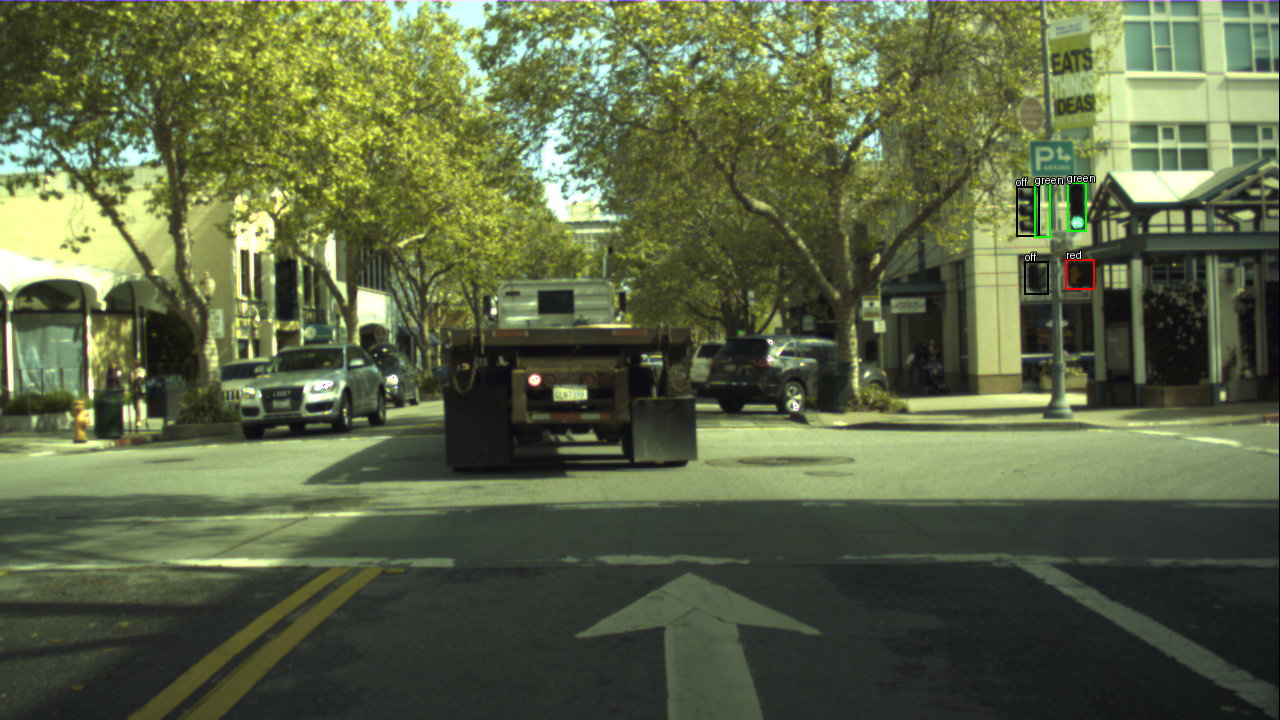

In [9]:
# In[8]: run on an example
out_img, dets = detect_and_classify("../new_dataset/test/rgb/test/25000.png")
print(dets)
out_img  # in Jupyter this will render the image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[{'box': [356.0500793457031, 108.54312896728516, 430.749755859375, 153.131591796875], 'color': 'red'}, {'box': [627.1809692382812, 277.6177673339844, 644.2671508789062, 321.5562438964844], 'color': 'red'}]


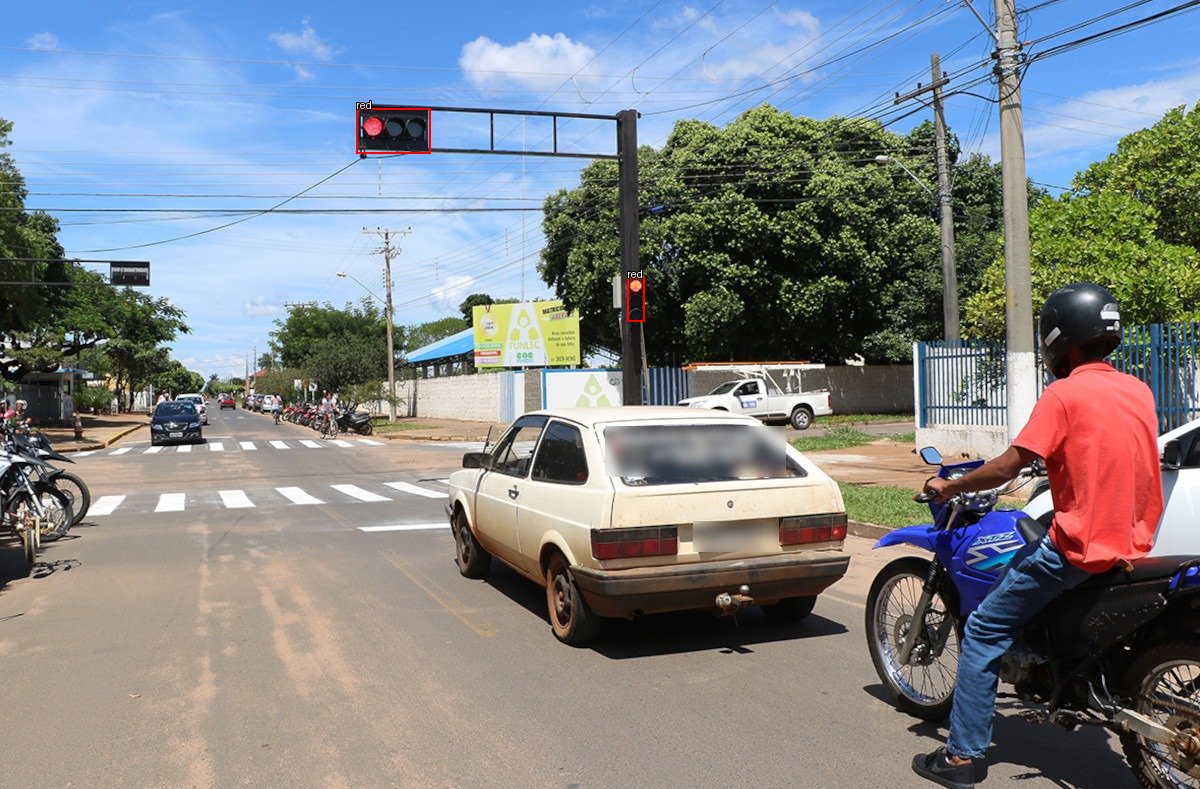

In [10]:
out_img, dets = detect_and_classify("../new_dataset/random-jp.jpeg")
print(dets)
out_img  # in Jupyter this will render the image

[]


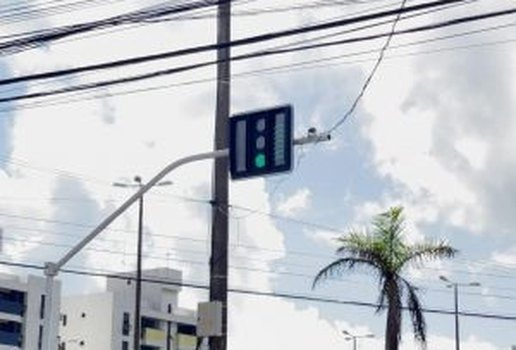

In [11]:
out_img, dets = detect_and_classify("../new_dataset/random-jp2.jpeg")
print(dets)
out_img  # in Jupyter this will render the image

In [12]:
test_img = Image.open("../new_dataset/random-jp2.jpeg").convert("RGB")

# box will crop 30% from above and 20% from the other parts to the center
box = np.array([0.3 * test_img.size[0], 0.2 * test_img.size[1], 0.7 * test_img.size[0], 0.8 * test_img.size[1]])

# classify color only
classify_color(test_img, box)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


'off'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[{'box': [75.67912292480469, 62.8425407409668, 91.0884017944336, 76.6156005859375], 'color': 'green'}, {'box': [162.91311645507812, 82.30437469482422, 169.1073760986328, 97.57276153564453], 'color': 'off'}]


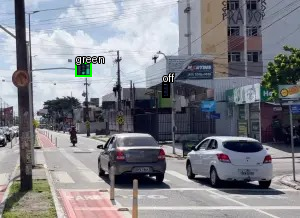

In [13]:
out_img, dets = detect_and_classify("../new_dataset/random-jp3.jpeg")
print(dets)
out_img  # in Jupyter this will render the image

Run sequence frames

In [ ]:
# In[9]: run on a sequence of frames “like a video”
import glob, os, time
from IPython.display import display, clear_output

# 1) adjust these
frame_pattern = "../new_dataset/test/rgb/test/*.png"   # your frame files
output_dir    = "../new_dataset/annotated_frames"       # where to save annotated frames
fps           = 10                       # display frame‐rate

# 2) prepare
os.makedirs(output_dir, exist_ok=True)
frame_paths = sorted(glob.glob(frame_pattern))

# 3) loop through frames
for idx, frame_path in enumerate(frame_paths):
    if int(frame_path.split("/")[-1].split('.png')[0]) <= 25000:
        continue
    out_img, dets = detect_and_classify(frame_path, score_thresh=0.6)

    # display in notebook
    clear_output(wait=True)
    display(out_img)

    # save annotated frame
    base = os.path.basename(frame_path)
    out_img.save(os.path.join(output_dir, f"annot_{base}"))

    # maintain approx. fps
    time.sleep(0.1/fps)

# At the end you'll have all your annotated frames in 
# and seen them play back in the notebook. You can stitch them into a video
# afterwards (e.g. with ffmpeg or imageio) if you like.